# Assignment 2 - Survival Analysis

# S M Nazarat Hossain

# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import statsmodels.api as sm
#import seaborn as sb

In [2]:
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter

# Loading Data

In [3]:
df = pd.read_excel('Cancer patient data.xlsx')

In [4]:
df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
3,1932-07-28,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT


In [5]:
df.rename(columns={"LUNG DT":"LUNG_DT"}, inplace=True)

In [6]:
df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
3,1932-07-28,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT


# Part A: Data Preparation

####  Removing all patients who were diagnosed after 8/25/16

In [7]:
cutoff = pd.to_datetime("8/25/16")

In [8]:
L = df['LUNG_DT'] > cutoff
L = ~L

P = df['PANCREAS_DT'] > cutoff
P = ~P

T = df['THYROID_DT'] > cutoff
T = ~T

C = df['COLORECTAL_DT'] > cutoff
C = ~C

M = df['MELANOMA_DT'] > cutoff
M = ~M

In [9]:
df_sub = df[L & P & T & C & M].copy()

In [10]:
df_sub.shape

(8463, 14)

#### Right Censoring the data where we don't know what happened to the patient after the study ended on "8/2/5/016"

In [11]:
df_sub['DATE_CUTOFF'] = cutoff ##adding the cutoff series to the dataframe with column title as "DATE_CUTOFF"
df_sub['Censored'] = (df_sub['DEATH_DATE_off'] < df_sub['DATE_CUTOFF'])*1 ##create the column "Censored" based on the patients that died after the cutoff date

In [12]:
df_sub['Censored'] = 1 - df_sub['Censored'] ##censoring the data after 8/25/2016 so this will flip the binary values

In [13]:
df_sub['Censored'].value_counts()##determining the number of censored values "0" being censored and "1" is within the scope of the experiment/intervention

1    8063
0     400
Name: Censored, dtype: int64

#### Removing all patients who do not have a diagnosis date

In [14]:
df_sub = df_sub[(df_sub['LUNG_DT'].notnull()) | (df_sub['PANCREAS_DT'].notnull()) | (df_sub['THYROID_DT'].notnull()) | (df_sub['COLORECTAL_DT'].notnull()) | (df_sub['MELANOMA_DT'].notnull())]

In [15]:
df_sub.shape

(4148, 16)

In [16]:
df_sub.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,DATE_CUTOFF,Censored
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,2016-08-25,1
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,2016-08-25,0
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,2016-08-25,0
6,1946-11-03,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,2016-08-25,1
7,1938-06-10,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,2016-08-25,1


#### Categorizing race into White, African-American, Asian/Mideast-Indian, and Others.

In [17]:
df_sub['race'].value_counts()

White                                     2815
Black/African-American                     956
Unknown                                    163
Asian/Mideast Indian                       117
More than one Race                          49
Patient Declined                            25
Native Hawaiian/Other Pacific Islander      17
American Indian or Alaska Native             4
Name: race, dtype: int64

In [18]:
def what_race(df):
    if df['race'] == 'Black/African-American':
        val = 'Black/African-American'
    elif df['race'] == 'White':
        val = 'White'
    elif df['race'] == 'Native Hawaiian/Other Pacific Islander':
        val = 'Asian/Mideast Indian'
    elif df['race'] == 'Asian/Mideast Indian':
        val = 'Asian/Mideast Indian'
    elif df['race'] == 'American Indian or Alaska Native':
        val = 'Other'
    else:
        val = 'Other'
    return val

In [19]:
df_sub['Race'] = df_sub.apply(what_race, axis = 1) 

In [20]:
df_sub['Race'].value_counts()

White                     2815
Black/African-American     956
Other                      243
Asian/Mideast Indian       134
Name: Race, dtype: int64

In [21]:
df_sub.isnull().sum()

BIRTH_DATE_off       0
DEATH_DATE_off    3822
sex                  0
race                 2
LUNG                 0
PANCREAS             0
THYROID              0
COLORECTAL           0
MELANOMA             0
LUNG_DT           2665
PANCREAS_DT       3490
THYROID_DT        3404
COLORECTAL_DT     3202
MELANOMA_DT       3802
DATE_CUTOFF          0
Censored             0
Race                 0
dtype: int64

#### Missing Death_Date is replcaing by cutoff date

In [22]:
df_sub['DEATH_DATE_off'].fillna(value = cutoff, inplace = True )

In [23]:
df_sub.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,DATE_CUTOFF,Censored,Race
0,1959-12-02,2016-08-25,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,2016-08-25,1,Black/African-American
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,2016-08-25,0,Black/African-American
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,2016-08-25,0,Black/African-American
6,1946-11-03,2016-08-25,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,2016-08-25,1,Black/African-American
7,1938-06-10,2016-08-25,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,2016-08-25,1,Black/African-American


#### Calculating age

In [24]:
df_sub['age'] = round(((df_sub['DEATH_DATE_off'] - df_sub['BIRTH_DATE_off']).dt.days)/365, 0).astype(int)

In [25]:
df_sub.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,DATE_CUTOFF,Censored,Race,age
0,1959-12-02,2016-08-25,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,2016-08-25,1,Black/African-American,57
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,2016-08-25,0,Black/African-American,60
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,2016-08-25,0,Black/African-American,69
6,1946-11-03,2016-08-25,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,2016-08-25,1,Black/African-American,70
7,1938-06-10,2016-08-25,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,2016-08-25,1,Black/African-American,78


#### Creating different age group

In [26]:
bins = [0,10,20,30,40,50,60,70,80,90,100,np.inf]
names = ['<10', '11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100','100+']
df_sub['Age_Range'] = pd.cut(df_sub['age'], bins, labels=names)

In [27]:
# df_sub.head()

In [28]:
df_sub.isnull().sum()

BIRTH_DATE_off       0
DEATH_DATE_off       0
sex                  0
race                 2
LUNG                 0
PANCREAS             0
THYROID              0
COLORECTAL           0
MELANOMA             0
LUNG_DT           2665
PANCREAS_DT       3490
THYROID_DT        3404
COLORECTAL_DT     3202
MELANOMA_DT       3802
DATE_CUTOFF          0
Censored             0
Race                 0
age                  0
Age_Range            0
dtype: int64

# Part B

### Exploratory Data Analysis on newly formed features

Analyze survival rate by gender, race and age group in deciles (11-20, 21-30, ....) for patients with following cancer:
1.	lung
2.	pancreas
3.	thyroid
4.	colorectal
5.	melanoma
    

# Creating data set for each cancer category

# Lung

In [29]:
df_sub.columns

Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'LUNG', 'PANCREAS',
       'THYROID', 'COLORECTAL', 'MELANOMA', 'LUNG_DT', 'PANCREAS_DT',
       'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range'],
      dtype='object')

In [30]:
## Lung Data

In [31]:
df_Lung = df_sub[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'LUNG','LUNG_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range']]

In [32]:
df_Lung.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,LUNG,LUNG_DT,DATE_CUTOFF,Censored,Race,age,Age_Range
0,1959-12-02,2016-08-25,Male,1,2013-09-01,2016-08-25,1,Black/African-American,57,51-60
1,1955-11-18,2016-04-20,Male,1,2016-04-02,2016-08-25,0,Black/African-American,60,51-60
2,1946-01-14,2015-05-25,Female,1,2015-04-11,2016-08-25,0,Black/African-American,69,61-70
6,1946-11-03,2016-08-25,Female,0,NaT,2016-08-25,1,Black/African-American,70,61-70
7,1938-06-10,2016-08-25,Female,0,NaT,2016-08-25,1,Black/African-American,78,71-80


In [33]:
df_Lung.isnull().sum()

BIRTH_DATE_off       0
DEATH_DATE_off       0
sex                  0
LUNG                 0
LUNG_DT           2665
DATE_CUTOFF          0
Censored             0
Race                 0
age                  0
Age_Range            0
dtype: int64

In [34]:
df_Lung=df_Lung.dropna()

In [35]:
df_Lung['Lung_Duration'] = (df_Lung['DEATH_DATE_off'] - df_Lung['LUNG_DT']).dt.days.astype(int)

In [36]:
df_Lung.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,LUNG,LUNG_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Lung_Duration
0,1959-12-02,2016-08-25,Male,1,2013-09-01,2016-08-25,1,Black/African-American,57,51-60,1089
1,1955-11-18,2016-04-20,Male,1,2016-04-02,2016-08-25,0,Black/African-American,60,51-60,18
2,1946-01-14,2015-05-25,Female,1,2015-04-11,2016-08-25,0,Black/African-American,69,61-70,44
9,1957-10-18,2016-08-25,Male,1,2012-11-29,2016-08-25,1,Black/African-American,59,51-60,1365
12,1940-02-04,2016-08-25,Male,1,2013-05-21,2016-08-25,1,Black/African-American,77,71-80,1192


### survival rate by gender

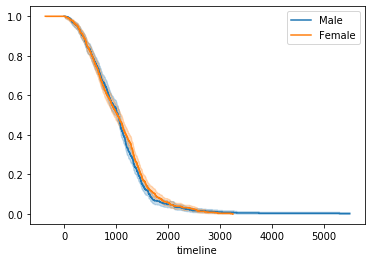

In [37]:
kmf = KaplanMeierFitter()

T = df_Lung['Lung_Duration']
E = df_Lung['Censored']


groups = df_Lung['sex']

ix1 = (groups == 'Male')
ix2 = (groups == 'Female')

kmf.fit(T[ix1], E[ix1], label='Male')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Female')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


### survival rate by race

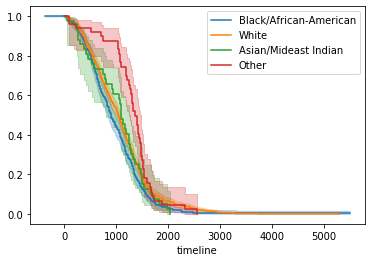

In [38]:
kmf = KaplanMeierFitter()

T = df_Lung['Lung_Duration']
E = df_Lung['Censored']


groups =  df_Lung['Race']

ix1 = (groups == 'Black/African-American')
ix2 = (groups == 'White')
ix3 = (groups == 'Asian/Mideast Indian')
ix4 = (groups == 'Other')

kmf.fit(T[ix1], E[ix1], label='Black/African-American')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='White')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='Asian/Mideast Indian')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='Other')         
ax3 = kmf.plot(ax=ax)

                  

### survival rate by age group 

In [39]:
df_Lung['Age_Range'].value_counts()

61-70     469
71-80     463
51-60     253
81-90     202
41-50      53
91-100     24
31-40      10
21-30       6
100+        1
11-20       1
<10         1
Name: Age_Range, dtype: int64

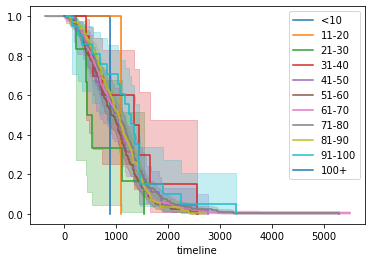

In [40]:
kmf = KaplanMeierFitter()

T = df_Lung['Lung_Duration']
E = df_Lung['Censored']


groups =  df_Lung['Age_Range']

ix1 = (groups == '<10')
ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
ix10 = (groups == '91-100')
ix11 = (groups == '100+')

kmf.fit(T[ix1], E[ix1], label='<10')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='11-20')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)


kmf.fit(T[ix10], E[ix10], label='91-100')         
ax9 = kmf.plot(ax=ax)

kmf.fit(T[ix11], E[ix11], label='100+')         
ax10 = kmf.plot(ax=ax)


    

# PANCREAS

In [41]:
df_Pancreas = df_sub[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'PANCREAS','PANCREAS_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range']]

In [42]:
df_Pancreas = df_Pancreas.dropna()

In [43]:
df_Pancreas['Pancreas_Duration'] = (df_Pancreas['DEATH_DATE_off'] - df_Pancreas['PANCREAS_DT']).dt.days.astype(int)

### Survival rate by Gender

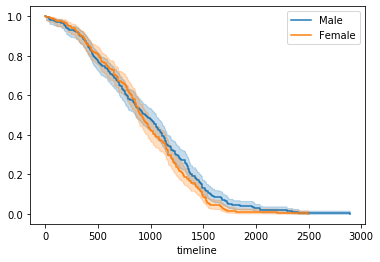

In [44]:
kmf = KaplanMeierFitter()

T = df_Pancreas['Pancreas_Duration']
E = df_Pancreas['Censored']


groups = df_Pancreas['sex']

ix1 = (groups == 'Male')
ix2 = (groups == 'Female')

kmf.fit(T[ix1], E[ix1], label='Male')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Female')       
ax1 = kmf.plot(ax=ax)


### Survival rate by Race

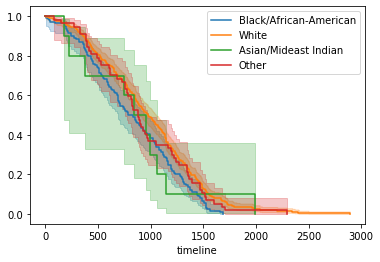

In [45]:
kmf = KaplanMeierFitter()

T = df_Pancreas['Pancreas_Duration']
E = df_Pancreas['Censored']


groups =  df_Pancreas['Race']

ix1 = (groups == 'Black/African-American')
ix2 = (groups == 'White')
ix3 = (groups == 'Asian/Mideast Indian')
ix4 = (groups == 'Other')

kmf.fit(T[ix1], E[ix1], label='Black/African-American')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='White')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='Asian/Mideast Indian')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='Other')         
ax3 = kmf.plot(ax=ax)

                  

### Survival rate by Race

In [46]:
df_Pancreas['Age_Range'].value_counts()

61-70     213
71-80     186
51-60     110
81-90     100
41-50      25
91-100     14
31-40       7
21-30       3
100+        0
11-20       0
<10         0
Name: Age_Range, dtype: int64

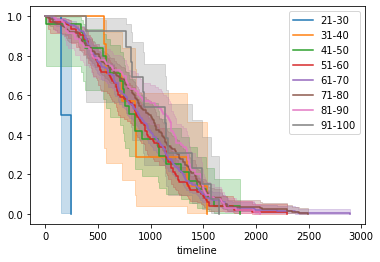

In [47]:
kmf = KaplanMeierFitter()

T = df_Pancreas['Pancreas_Duration']
E = df_Pancreas['Censored']


groups =  df_Pancreas['Age_Range']

#ix1 = (groups == '<10')
#ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
ix10 = (groups == '91-100')
#ix11 = (groups == '100+')

#kmf.fit(T[ix1], E[ix1], label='<10')    
#ax = kmf.plot()


#kmf.fit(T[ix2], E[ix2], label='11-20')       
#ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax = kmf.plot()


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)


kmf.fit(T[ix10], E[ix10], label='91-100')         
ax9 = kmf.plot(ax=ax)

#kmf.fit(T[ix11], E[ix11], label='100+')         
#ax10 = kmf.plot(ax=ax)


    

# THYROID

In [48]:
df_sub.columns

Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'LUNG', 'PANCREAS',
       'THYROID', 'COLORECTAL', 'MELANOMA', 'LUNG_DT', 'PANCREAS_DT',
       'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range'],
      dtype='object')

In [49]:
## THYROID Data

In [50]:
df_Thyroid = df_sub[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'THYROID','THYROID_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range']]

In [51]:
df_Thyroid.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,THYROID,THYROID_DT,DATE_CUTOFF,Censored,Race,age,Age_Range
0,1959-12-02,2016-08-25,Male,0,NaT,2016-08-25,1,Black/African-American,57,51-60
1,1955-11-18,2016-04-20,Male,0,NaT,2016-08-25,0,Black/African-American,60,51-60
2,1946-01-14,2015-05-25,Female,0,NaT,2016-08-25,0,Black/African-American,69,61-70
6,1946-11-03,2016-08-25,Female,1,2012-11-29,2016-08-25,1,Black/African-American,70,61-70
7,1938-06-10,2016-08-25,Female,1,2012-06-24,2016-08-25,1,Black/African-American,78,71-80


In [52]:
df_Thyroid.isnull().sum()

BIRTH_DATE_off       0
DEATH_DATE_off       0
sex                  0
THYROID              0
THYROID_DT        3404
DATE_CUTOFF          0
Censored             0
Race                 0
age                  0
Age_Range            0
dtype: int64

In [53]:
df_Thyroid=df_Thyroid.dropna()


In [54]:
df_Thyroid['Thyroid_Duration'] = (df_Thyroid['DEATH_DATE_off'] - df_Thyroid['THYROID_DT']).dt.days.astype(int)

In [55]:
df_Thyroid.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,THYROID,THYROID_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Thyroid_Duration
6,1946-11-03,2016-08-25,Female,1,2012-11-29,2016-08-25,1,Black/African-American,70,61-70,1365
7,1938-06-10,2016-08-25,Female,1,2012-06-24,2016-08-25,1,Black/African-American,78,71-80,1523
28,1948-02-17,2016-08-25,Female,1,2012-09-02,2016-08-25,1,Black/African-American,69,61-70,1453
32,1949-09-04,2016-08-25,Female,1,2014-03-19,2016-08-25,1,White,67,61-70,890
98,1949-12-15,2016-08-25,Female,1,2013-02-26,2016-08-25,1,Black/African-American,67,61-70,1276


### survival rate by gender

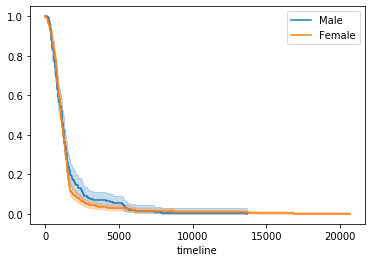

In [56]:
kmf = KaplanMeierFitter()

T = df_Thyroid['Thyroid_Duration']
E = df_Thyroid['Censored']


groups = df_Thyroid['sex']

ix1 = (groups == 'Male')
ix2 = (groups == 'Female')

kmf.fit(T[ix1], E[ix1], label='Male')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Female')        
ax1 = kmf.plot(ax=ax)


### survival rate by race

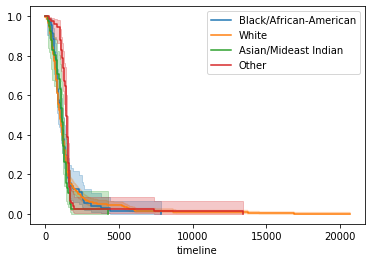

In [57]:
kmf = KaplanMeierFitter()

T = df_Thyroid['Thyroid_Duration']
E = df_Thyroid['Censored']


groups =  df_Thyroid['Race']

ix1 = (groups == 'Black/African-American')
ix2 = (groups == 'White')
ix3 = (groups == 'Asian/Mideast Indian')
ix4 = (groups == 'Other')

kmf.fit(T[ix1], E[ix1], label='Black/African-American')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='White')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='Asian/Mideast Indian')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='Other')         
ax3 = kmf.plot(ax=ax)

                  

### survival rate by age group 

In [58]:
df_Thyroid['Age_Range'].value_counts()

61-70     175
51-60     168
41-50     141
31-40     104
71-80      71
21-30      44
11-20      23
81-90      17
<10         1
100+        0
91-100      0
Name: Age_Range, dtype: int64

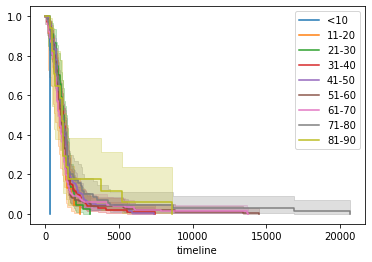

In [59]:
kmf = KaplanMeierFitter()

T = df_Thyroid['Thyroid_Duration']
E = df_Thyroid['Censored']


groups =  df_Thyroid['Age_Range']

ix1 = (groups == '<10')
ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
#ix10 = (groups == '91-100')
#ix11 = (groups == '100+')

kmf.fit(T[ix1], E[ix1], label='<10')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='11-20')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)



    

# COLORECTAL

In [60]:
df_sub.columns

Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'LUNG', 'PANCREAS',
       'THYROID', 'COLORECTAL', 'MELANOMA', 'LUNG_DT', 'PANCREAS_DT',
       'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range'],
      dtype='object')

In [62]:
df_Colorectal = df_sub[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'COLORECTAL','COLORECTAL_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range']]

In [63]:
df_Colorectal.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,COLORECTAL,COLORECTAL_DT,DATE_CUTOFF,Censored,Race,age,Age_Range
0,1959-12-02,2016-08-25,Male,0,NaT,2016-08-25,1,Black/African-American,57,51-60
1,1955-11-18,2016-04-20,Male,0,NaT,2016-08-25,0,Black/African-American,60,51-60
2,1946-01-14,2015-05-25,Female,0,NaT,2016-08-25,0,Black/African-American,69,61-70
6,1946-11-03,2016-08-25,Female,0,NaT,2016-08-25,1,Black/African-American,70,61-70
7,1938-06-10,2016-08-25,Female,0,NaT,2016-08-25,1,Black/African-American,78,71-80


In [64]:
df_Colorectal.isnull().sum()

BIRTH_DATE_off       0
DEATH_DATE_off       0
sex                  0
COLORECTAL           0
COLORECTAL_DT     3202
DATE_CUTOFF          0
Censored             0
Race                 0
age                  0
Age_Range            0
dtype: int64

In [65]:
df_Colorectal=df_Colorectal.dropna()

In [66]:
df_Colorectal['Colorectal_Duration'] = (df_Colorectal['DEATH_DATE_off'] - df_Colorectal['COLORECTAL_DT']).dt.days.astype(int)

In [67]:
df_Colorectal.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,COLORECTAL,COLORECTAL_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Colorectal_Duration
13,1971-08-11,2016-08-25,Female,1,2014-01-01,2016-08-25,1,Black/African-American,45,41-50,967
14,1948-03-22,2016-01-07,Female,1,2014-09-30,2016-08-25,0,Black/African-American,68,61-70,464
16,1946-01-09,2016-08-25,Female,1,2013-09-14,2016-08-25,1,Black/African-American,71,71-80,1076
36,1970-12-19,2016-08-25,Female,1,2013-12-09,2016-08-25,1,White,46,41-50,990
41,1928-03-25,2016-08-25,Female,1,2013-12-11,2016-08-25,1,Black/African-American,88,81-90,988


### survival rate by gender

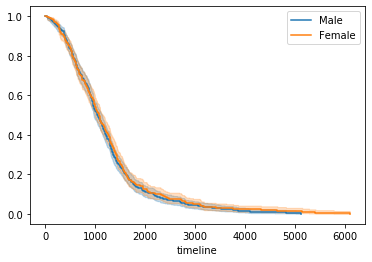

In [68]:
kmf = KaplanMeierFitter()

T = df_Colorectal['Colorectal_Duration']
E = df_Colorectal['Censored']


groups = df_Colorectal['sex']

ix1 = (groups == 'Male')
ix2 = (groups == 'Female')

kmf.fit(T[ix1], E[ix1], label='Male')   
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Female')        
ax1 = kmf.plot(ax=ax)


### survival rate by race

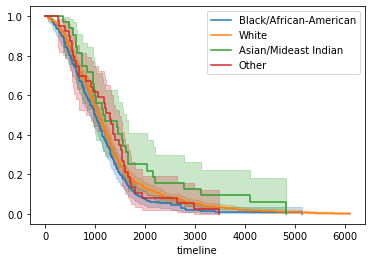

In [69]:
kmf = KaplanMeierFitter()

T = df_Colorectal['Colorectal_Duration']
E = df_Colorectal['Censored']


groups =  df_Colorectal['Race']

ix1 = (groups == 'Black/African-American')
ix2 = (groups == 'White')
ix3 = (groups == 'Asian/Mideast Indian')
ix4 = (groups == 'Other')

kmf.fit(T[ix1], E[ix1], label='Black/African-American')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='White')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='Asian/Mideast Indian')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='Other')         
ax3 = kmf.plot(ax=ax)

                  

### survival rate by age group 

In [70]:
df_Colorectal['Age_Range'].value_counts()

61-70     287
51-60     224
71-80     177
81-90     105
41-50      90
31-40      37
91-100     20
21-30       5
11-20       1
100+        0
<10         0
Name: Age_Range, dtype: int64

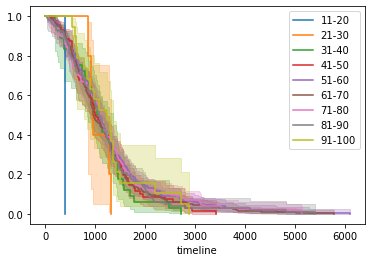

In [71]:
kmf = KaplanMeierFitter()

T = df_Colorectal['Colorectal_Duration']
E = df_Colorectal['Censored']


groups =  df_Colorectal['Age_Range']

#ix1 = (groups == '<10')
ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
ix10 = (groups == '91-100')
#ix11 = (groups == '100+')

#kmf.fit(T[ix1], E[ix1], label='<10')    
#ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='11-20')       
ax = kmf.plot()

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)


kmf.fit(T[ix10], E[ix10], label='91-100')         
ax9 = kmf.plot(ax=ax)

#kmf.fit(T[ix11], E[ix11], label='100+')         
#ax10 = kmf.plot(ax=ax)


    

# MELANOMA

In [72]:
df_sub.columns

Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'LUNG', 'PANCREAS',
       'THYROID', 'COLORECTAL', 'MELANOMA', 'LUNG_DT', 'PANCREAS_DT',
       'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range'],
      dtype='object')

In [74]:
df_Melanoma = df_sub[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'MELANOMA','MELANOMA_DT', 'DATE_CUTOFF', 'Censored',
       'Race', 'age', 'Age_Range']]

In [75]:
df_Melanoma.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,MELANOMA,MELANOMA_DT,DATE_CUTOFF,Censored,Race,age,Age_Range
0,1959-12-02,2016-08-25,Male,0,NaT,2016-08-25,1,Black/African-American,57,51-60
1,1955-11-18,2016-04-20,Male,0,NaT,2016-08-25,0,Black/African-American,60,51-60
2,1946-01-14,2015-05-25,Female,0,NaT,2016-08-25,0,Black/African-American,69,61-70
6,1946-11-03,2016-08-25,Female,0,NaT,2016-08-25,1,Black/African-American,70,61-70
7,1938-06-10,2016-08-25,Female,0,NaT,2016-08-25,1,Black/African-American,78,71-80


In [76]:
df_Melanoma.isnull().sum()

BIRTH_DATE_off       0
DEATH_DATE_off       0
sex                  0
MELANOMA             0
MELANOMA_DT       3802
DATE_CUTOFF          0
Censored             0
Race                 0
age                  0
Age_Range            0
dtype: int64

In [77]:
df_Melanoma=df_Melanoma.dropna()

In [78]:
df_Melanoma['Melanoma_Duration'] = (df_Melanoma['DEATH_DATE_off'] - df_Melanoma['MELANOMA_DT']).dt.days.astype(int)

In [79]:
df_Melanoma.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,MELANOMA,MELANOMA_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Melanoma_Duration
146,1928-06-22,2016-08-25,Male,1,2015-03-03,2016-08-25,1,White,88,81-90,541
178,1933-12-27,2014-11-27,Male,1,2012-12-20,2016-08-25,0,White,81,81-90,707
196,1924-04-08,2016-08-25,Female,1,2014-05-31,2016-08-25,1,White,92,91-100,817
341,1957-10-04,2016-08-25,Female,1,2013-05-19,2016-08-25,1,White,59,51-60,1194
354,1966-08-03,2016-08-25,Male,1,2015-03-09,2016-08-25,1,White,50,41-50,535


### survival rate by gender

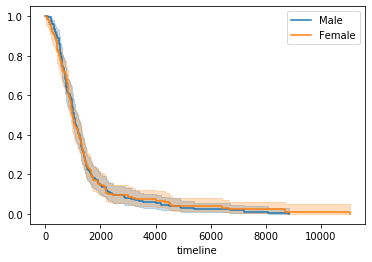

In [80]:
kmf = KaplanMeierFitter()

T = df_Melanoma['Melanoma_Duration']
E = df_Melanoma['Censored']


groups = df_Melanoma['sex']

ix1 = (groups == 'Male')
ix2 = (groups == 'Female')

kmf.fit(T[ix1], E[ix1], label='Male')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Female')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


### survival rate by race

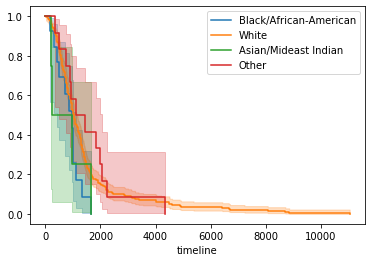

In [81]:
kmf = KaplanMeierFitter()

T = df_Melanoma['Melanoma_Duration']
E = df_Melanoma['Censored']


groups =  df_Melanoma['Race']

ix1 = (groups == 'Black/African-American')
ix2 = (groups == 'White')
ix3 = (groups == 'Asian/Mideast Indian')
ix4 = (groups == 'Other')

kmf.fit(T[ix1], E[ix1], label='Black/African-American')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='White')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='Asian/Mideast Indian')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='Other')         
ax3 = kmf.plot(ax=ax)

                  

### survival rate by age group 

In [82]:
df_Melanoma['Age_Range'].value_counts()

61-70     93
71-80     70
51-60     57
41-50     41
81-90     34
31-40     24
21-30     16
91-100     8
11-20      3
100+       0
<10        0
Name: Age_Range, dtype: int64

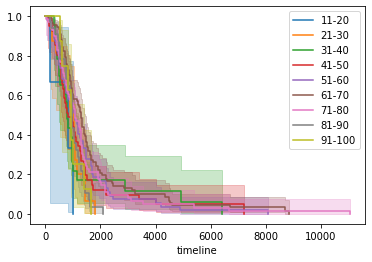

In [83]:
kmf = KaplanMeierFitter()

T = df_Melanoma['Melanoma_Duration']
E = df_Melanoma['Censored']


groups =  df_Melanoma['Age_Range']

#ix1 = (groups == '<10')
ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
ix10 = (groups == '91-100')
#ix11 = (groups == '100+')

#kmf.fit(T[ix1], E[ix1], label='<10')    
#ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='11-20')       
ax = kmf.plot()

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)


kmf.fit(T[ix10], E[ix10], label='91-100')         
ax9 = kmf.plot(ax=ax)

#kmf.fit(T[ix11], E[ix11], label='100+')         
#ax10 = kmf.plot(ax=ax)


    

# Part C: Questions

## 1. Which cancer has the highest survival for this cohort?

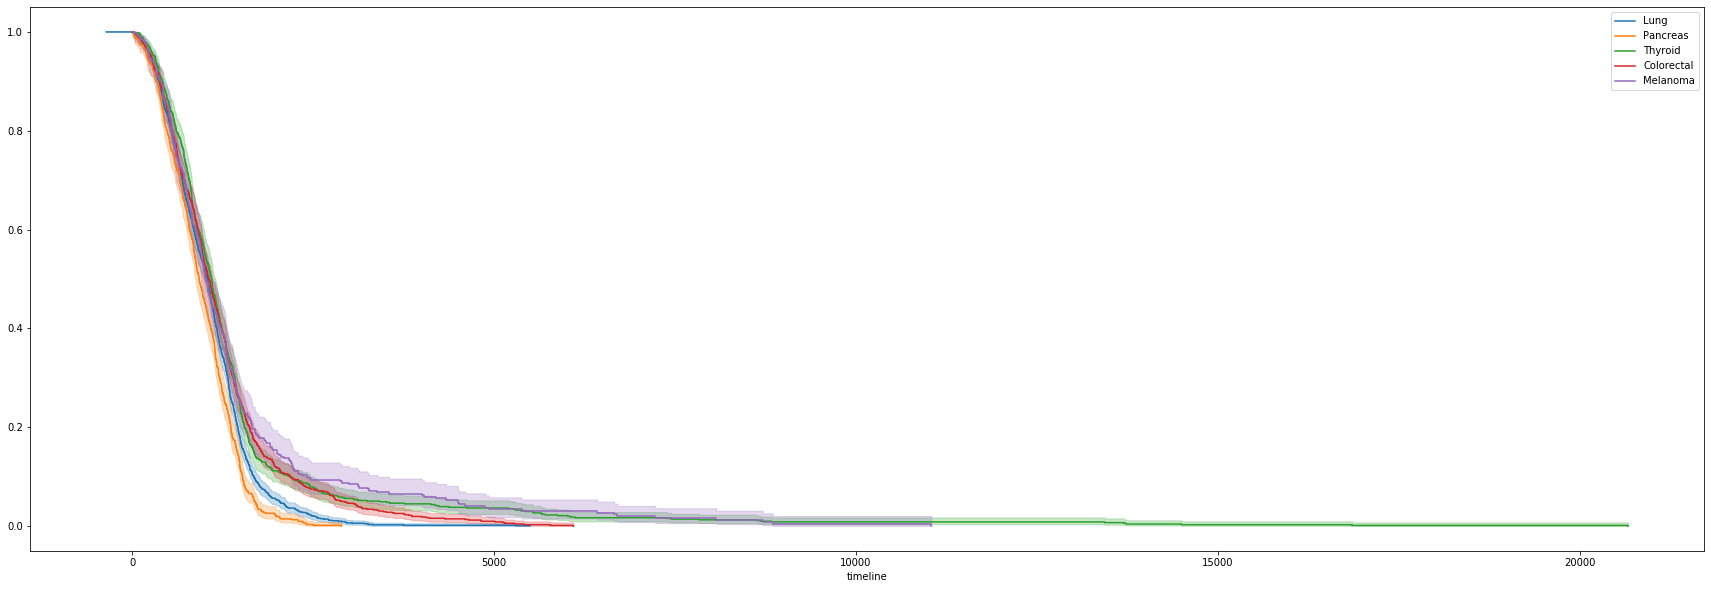

In [84]:
kmf = KaplanMeierFitter() 

kmf.fit(df_Lung['Lung_Duration'], df_Lung['Censored'], label='Lung')  
ax = kmf.plot()

kmf.fit(df_Pancreas['Pancreas_Duration'], df_Pancreas['Censored'], label='Pancreas')        
ax1 = kmf.plot(ax=ax)

kmf.fit(df_Thyroid['Thyroid_Duration'], df_Thyroid['Censored'], label='Thyroid')       
ax2 = kmf.plot(ax=ax1)

kmf.fit(df_Colorectal['Colorectal_Duration'], df_Colorectal['Censored'], label='Colorectal')     
ax3 = kmf.plot(ax=ax2)

kmf.fit(df_Melanoma['Melanoma_Duration'], df_Melanoma['Censored'], label='Melanoma')        
kmf.plot(ax=ax3,figsize = (30,10))

Highest survival rate for the cohort is Thyroid.

## 2. Which cancer has the lowest survival for this cohort?

Lowest survival rate for the cohort is Pancreatic cancer.

## 3. how many patients had 2 cancer diagnosis?

In [85]:
df_sub['Count of diagnosis'] = df_sub['LUNG'] + df_sub['PANCREAS'] + df_sub['THYROID'] + df_sub['COLORECTAL'] + df_sub['MELANOMA'] 

In [86]:
df_sub['Count of diagnosis'].value_counts()

1    4119
2      29
Name: Count of diagnosis, dtype: int64

29 Patients.

## 4. which age group has the lowest survival after 400 days since cancer diagnosis?

From the figure of survivar rate by age group, it is observed that you age groups (11-20 and 21-30) have lowest survival rate after 400 days since cancer diagnosis. However, the number of data points is too small for them.

## 5. what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [87]:
df_Colorectal_Female = df_Colorectal[df_Colorectal['sex'] == 'Female']

In [88]:
df_Colorectal_Female.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,COLORECTAL,COLORECTAL_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Colorectal_Duration
13,1971-08-11,2016-08-25,Female,1,2014-01-01,2016-08-25,1,Black/African-American,45,41-50,967
14,1948-03-22,2016-01-07,Female,1,2014-09-30,2016-08-25,0,Black/African-American,68,61-70,464
16,1946-01-09,2016-08-25,Female,1,2013-09-14,2016-08-25,1,Black/African-American,71,71-80,1076
36,1970-12-19,2016-08-25,Female,1,2013-12-09,2016-08-25,1,White,46,41-50,990
41,1928-03-25,2016-08-25,Female,1,2013-12-11,2016-08-25,1,Black/African-American,88,81-90,988


In [89]:
kmf_Female = KaplanMeierFitter()
kmf_Female.fit(df_Colorectal_Female['Colorectal_Duration'], df_Colorectal_Female['Censored'], label = 'Female')

<lifelines.KaplanMeierFitter:"Female", fitted with 423 total observations, 25 right-censored observations>

Text(0, 0.5, 'Survival')

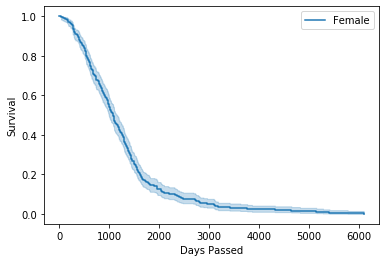

In [91]:
kmf_Female.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [92]:
kmf_Female.predict(1000)

0.5409275029971161

#### Survival Rate for females with colorectal cancer after 1000 days since diagnosis is ~0.54or 54%

# 6. What is the survival rate for males with lung cancer after 300 days since diagnosis?

In [93]:
df_Lung_Male = df_Lung[df_Lung['sex'] == 'Male']

In [94]:
df_Lung_Male.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,LUNG,LUNG_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Lung_Duration
0,1959-12-02,2016-08-25,Male,1,2013-09-01,2016-08-25,1,Black/African-American,57,51-60,1089
1,1955-11-18,2016-04-20,Male,1,2016-04-02,2016-08-25,0,Black/African-American,60,51-60,18
9,1957-10-18,2016-08-25,Male,1,2012-11-29,2016-08-25,1,Black/African-American,59,51-60,1365
12,1940-02-04,2016-08-25,Male,1,2013-05-21,2016-08-25,1,Black/African-American,77,71-80,1192
25,1953-08-25,2016-08-25,Male,1,2015-01-14,2016-08-25,1,Black/African-American,63,61-70,589


In [95]:
kmf_Male_Lung = KaplanMeierFitter()
kmf_Male_Lung.fit(df_Lung_Male['Lung_Duration'], df_Lung_Male['Censored'], label = 'Male')

<lifelines.KaplanMeierFitter:"Male", fitted with 718 total observations, 95 right-censored observations>

Text(0, 0.5, 'Survival')

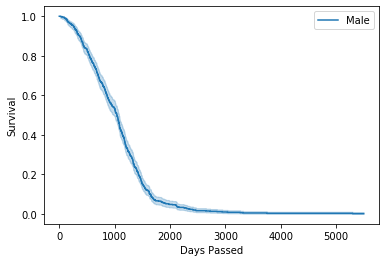

In [97]:
kmf_Male_Lung.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [98]:
kmf_Male_Lung.predict(300)

0.930039896782673

### Survival Rate for males with lung cancer after 300 days since diagnosis is ~0.93 or 93%

# 7.	What is the survival rate for females with melanoma cancer after 1200 days since diagnosis?

In [99]:
df_Melanoma_Female = df_Melanoma[df_Melanoma['sex'] == 'Female']

In [100]:
df_Melanoma_Female.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,MELANOMA,MELANOMA_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Melanoma_Duration
196,1924-04-08,2016-08-25,Female,1,2014-05-31,2016-08-25,1,White,92,91-100,817
341,1957-10-04,2016-08-25,Female,1,2013-05-19,2016-08-25,1,White,59,51-60,1194
422,1961-08-24,2016-08-25,Female,1,2012-01-09,2016-08-25,1,White,55,51-60,1690
638,1952-06-08,2016-08-25,Female,1,2015-02-08,2016-08-25,1,White,64,61-70,564
708,1961-04-14,2016-08-25,Female,1,2012-07-26,2016-08-25,1,White,55,51-60,1491


In [101]:
kmf_Female_Melanoma = KaplanMeierFitter()
kmf_Female_Melanoma.fit(df_Melanoma_Female['Melanoma_Duration'], df_Melanoma_Female['Censored'], label = 'Female')

<lifelines.KaplanMeierFitter:"Female", fitted with 160 total observations, 8 right-censored observations>

Text(0, 0.5, 'Survival')

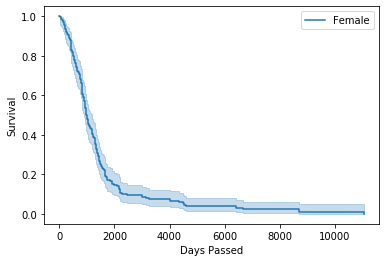

In [103]:
kmf_Female_Melanoma.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [104]:
kmf_Female_Melanoma.predict(1200)

0.4041815360339413

Survival Rate for females with melanoma cancer after 1200 days since diagnosis is ~0.40 or 40%

# 8. what is the survival rate for males with thyroid cancer after 1500 days since diagnosis?

In [105]:
df_Thyroid_Male = df_Thyroid[df_Thyroid['sex'] == 'Male']

In [106]:
df_Thyroid_Male.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,THYROID,THYROID_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Thyroid_Duration
188,1928-10-10,2016-08-25,Male,1,2015-01-04,2016-08-25,1,Black/African-American,88,81-90,599
350,1940-07-09,2016-08-25,Male,1,2015-02-02,2016-08-25,1,White,76,71-80,570
370,1977-08-11,2016-08-25,Male,1,2015-08-26,2016-08-25,1,White,39,31-40,365
406,1959-03-04,2016-08-25,Male,1,2014-12-24,2016-08-25,1,Black/African-American,58,51-60,610
411,1953-07-20,2016-08-25,Male,1,1995-03-15,2016-08-25,1,Black/African-American,63,61-70,7834


In [107]:
kmf_Male_Thyroid = KaplanMeierFitter()
kmf_Male_Thyroid.fit(df_Thyroid_Male['Thyroid_Duration'], df_Thyroid_Male['Censored'], label = 'Male')

<lifelines.KaplanMeierFitter:"Male", fitted with 205 total observations, 5 right-censored observations>

Text(0, 0.5, 'Survival')

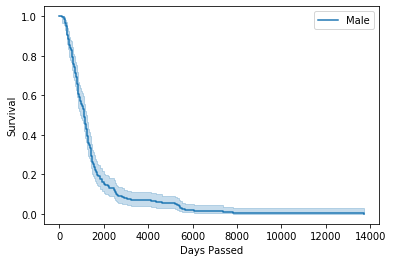

In [109]:
kmf_Male_Thyroid.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [110]:
kmf_Male_Thyroid.predict(1500)

0.26087975718986306

Survival Rate for males with thyroid cancer after 1500 days since diagnosis is 0.26 or 26%

# 9.	What is the survival rate for males with pancreatic cancer after 2200 days since diagnosis?

In [111]:
df_Pancreatic_Male = df_Pancreas[df_Pancreas['sex'] == 'Male']

In [112]:
df_Pancreatic_Male.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,PANCREAS,PANCREAS_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Pancreas_Duration
57,1938-06-24,2016-08-25,Male,1,2013-11-19,2016-08-25,1,White,78,71-80,1010
92,1952-08-30,2016-11-21,Male,1,2014-10-27,2016-08-25,1,Black/African-American,64,61-70,756
118,1956-07-15,2016-04-22,Male,1,2016-03-13,2016-08-25,0,Black/African-American,60,51-60,40
138,1958-03-09,2016-08-25,Male,1,2014-09-16,2016-08-25,1,Black/African-American,59,51-60,709
223,1930-08-11,2016-08-25,Male,1,2012-12-11,2016-08-25,1,Black/African-American,86,81-90,1353


In [113]:
kmf_Male_Pancreatic = KaplanMeierFitter()
kmf_Male_Pancreatic.fit(df_Pancreatic_Male['Pancreas_Duration'], df_Pancreatic_Male['Censored'], label = 'Male')

<lifelines.KaplanMeierFitter:"Male", fitted with 340 total observations, 14 right-censored observations>

Text(0, 0.5, 'Survival')

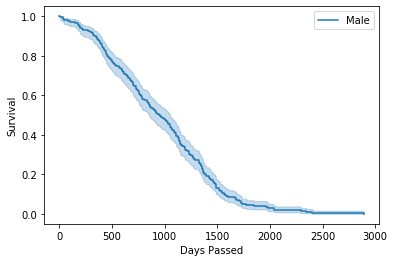

In [115]:
kmf_Male_Pancreatic.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [116]:
kmf_Male_Pancreatic.predict(2200)

0.018522666046588476

Survival Rate for males with pancreatic cancer after 2200 days since diagnosis is ~0.01 or 1%

# 10. What is the survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis?

In [117]:
df_Colorectal_African_American = df_Colorectal[df_Colorectal['Race'] == 'Black/African-American']

In [118]:
df_Colorectal_African_American.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,COLORECTAL,COLORECTAL_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Colorectal_Duration
13,1971-08-11,2016-08-25,Female,1,2014-01-01,2016-08-25,1,Black/African-American,45,41-50,967
14,1948-03-22,2016-01-07,Female,1,2014-09-30,2016-08-25,0,Black/African-American,68,61-70,464
16,1946-01-09,2016-08-25,Female,1,2013-09-14,2016-08-25,1,Black/African-American,71,71-80,1076
41,1928-03-25,2016-08-25,Female,1,2013-12-11,2016-08-25,1,Black/African-American,88,81-90,988
45,1947-06-12,2013-03-24,Male,1,2009-07-30,2016-08-25,0,Black/African-American,66,61-70,1333


In [119]:
kmf_African_American = KaplanMeierFitter()
kmf_African_American.fit(df_Colorectal_African_American['Colorectal_Duration'], df_Colorectal_African_American['Censored'], label = 'African_American')

<lifelines.KaplanMeierFitter:"African_American", fitted with 263 total observations, 30 right-censored observations>

Text(0, 0.5, 'Survival')

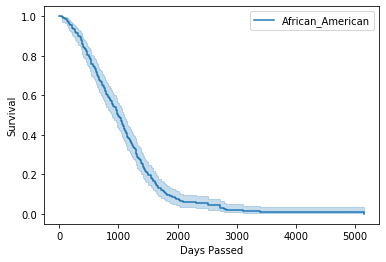

In [121]:
kmf_African_American.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [122]:
kmf_African_American.predict(2000)

0.07426928749574375

Survival Rate for african-americans with colorectal cancer after 2000 days since diagnosis is 0.07 or 7%

# 11.	What is the survival rate for Whites with lung cancer after 1000 days since diagnosis?

In [123]:
df_Lung_Whites = df_Lung[df_Lung['Race'] == 'White']

In [124]:
df_Lung_Whites.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,LUNG,LUNG_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Lung_Duration
38,1926-02-28,2016-08-25,Male,1,2015-12-01,2016-08-25,1,White,91,91-100,268
88,1945-07-12,2016-08-25,Male,1,2013-10-03,2016-08-25,1,White,71,71-80,1057
94,1947-01-14,2016-08-25,Male,1,2015-08-27,2016-08-25,1,White,70,61-70,364
158,1956-01-11,2014-12-11,Male,1,2014-10-13,2016-08-25,0,White,59,51-60,59
218,1931-11-23,2013-11-02,Female,1,2008-05-16,2016-08-25,0,White,82,81-90,1996


In [125]:
kmf_White_Lung = KaplanMeierFitter()
kmf_White_Lung.fit(df_Lung_Whites['Lung_Duration'], df_Lung_Whites['Censored'], label = 'White')

<lifelines.KaplanMeierFitter:"White", fitted with 910 total observations, 82 right-censored observations>

In [126]:
# kmf_Female.cumulative_density_

Text(0, 0.5, 'Survival')

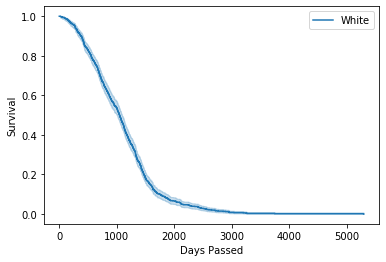

In [127]:
kmf_White_Lung.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [128]:
kmf_White_Lung.predict(1000)

0.5353798738532698

Survival Rate for whites with lung cancer after 1000 days since diagnosis is 0.53 or 53%

# 12.	What is the survival rate for African-Americans with melanoma cancer after 2 years since diagnosis?

In [129]:
df_Melanoma_African_American = df_Melanoma[df_Melanoma['Race'] == 'Black/African-American']

In [130]:
df_Melanoma_African_American.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,MELANOMA,MELANOMA_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Melanoma_Duration
1450,1937-11-25,2016-08-25,Male,1,2013-08-03,2016-08-25,1,Black/African-American,79,71-80,1118
1588,1996-09-16,2016-08-25,Female,1,2016-02-27,2016-08-25,1,Black/African-American,20,11-20,180
1629,1941-10-12,2016-08-25,Male,1,2015-10-04,2016-08-25,1,Black/African-American,75,71-80,326
1776,1950-03-13,2016-08-25,Female,1,2013-11-24,2016-08-25,1,Black/African-American,66,61-70,1005
1878,1985-10-26,2014-09-04,Female,1,2013-04-20,2016-08-25,0,Black/African-American,29,21-30,502


In [131]:
kmf_African_American = KaplanMeierFitter()
kmf_African_American.fit(df_Melanoma_African_American['Melanoma_Duration'], df_Melanoma_African_American['Censored'], label = 'African_American')

<lifelines.KaplanMeierFitter:"African_American", fitted with 14 total observations, 2 right-censored observations>

In [132]:
# kmf_Female.cumulative_density_

Text(0, 0.5, 'Survival')

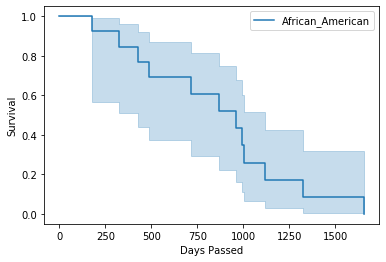

In [133]:
kmf_African_American.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [134]:
kmf_African_American.predict(730)

0.605769230769231

Survival Rate for african americans with melanoma cancer after 2 years (730) days since diagnosis is near 0.6 or 60%

# 13. What is the survival rate for Whites with pancreatic cancer after 3 years since diagnosis?

In [135]:
df_Pancreatic_White = df_Pancreas[df_Pancreas['Race'] == 'White']

In [136]:
df_Pancreatic_White.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,PANCREAS,PANCREAS_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Pancreas_Duration
57,1938-06-24,2016-08-25,Male,1,2013-11-19,2016-08-25,1,White,78,71-80,1010
314,1950-11-06,2016-08-25,Male,1,2011-12-03,2016-08-25,1,White,66,61-70,1727
414,1956-06-06,2016-08-25,Female,1,2013-04-04,2016-08-25,1,White,60,51-60,1239
437,1941-12-11,2016-08-25,Female,1,2013-07-09,2016-08-25,1,White,75,71-80,1143
461,1953-12-22,2016-08-25,Male,1,2015-07-09,2016-08-25,1,White,63,61-70,413


In [137]:
kmf_White_Pancreatic = KaplanMeierFitter()
kmf_White_Pancreatic.fit(df_Pancreatic_White['Pancreas_Duration'], df_Pancreatic_White['Censored'], label = 'White')

<lifelines.KaplanMeierFitter:"White", fitted with 444 total observations, 13 right-censored observations>

In [138]:
# kmf_Female.cumulative_density_

Text(0, 0.5, 'Survival')

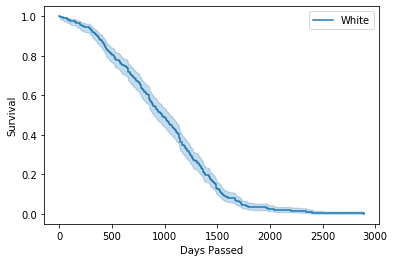

In [139]:
kmf_White_Pancreatic.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [140]:
kmf_White_Pancreatic.predict(1095)

0.4292873443640372

Survival rate for Whites with pancreatic cancer after 3 years (1095 days) since diagnosis is 0.43 or 43%

# 14. What is the survival rate for Asians with thyroid cancer after 1500 days since diagnosis?

In [141]:
df_Thyroid_Asian = df_Thyroid[df_Thyroid['Race'] == 'Asian/Mideast Indian']

In [142]:
df_Thyroid_Asian.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,THYROID,THYROID_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Thyroid_Duration
516,1929-02-28,2016-08-25,Female,1,2015-09-22,2016-08-25,1,Asian/Mideast Indian,88,81-90,338
1542,1986-02-15,2016-08-25,Female,1,2013-02-09,2016-08-25,1,Asian/Mideast Indian,31,31-40,1293
1975,1955-08-27,2016-08-25,Female,1,2014-07-09,2016-08-25,1,Asian/Mideast Indian,61,61-70,778
2191,1967-11-14,2016-08-25,Female,1,2013-12-07,2016-08-25,1,Asian/Mideast Indian,49,41-50,992
2212,1964-07-27,2016-08-25,Female,1,2011-10-13,2016-08-25,1,Asian/Mideast Indian,52,51-60,1778


In [143]:
kmf_Asian_Thyroid = KaplanMeierFitter()
kmf_Asian_Thyroid.fit(df_Thyroid_Asian['Thyroid_Duration'], df_Thyroid_Asian['Censored'], label = 'Asian')

<lifelines.KaplanMeierFitter:"Asian", fitted with 41 total observations, 1 right-censored observations>

Text(0, 0.5, 'Survival')

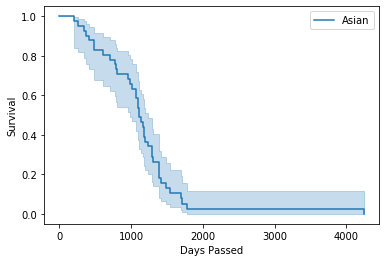

In [145]:
kmf_Asian_Thyroid.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [146]:
kmf_Asian_Thyroid.predict(1500)

0.1313320825515947

Survival Rate for asian with thyroid cancer after 1500 days since diagnosis is near 0.13 or 13%

# 15. which age group has the lowest survival for colorectal cancer at the end of the study?

In [147]:
df_Colorectal['Age_Range'].value_counts()

61-70     287
51-60     224
71-80     177
81-90     105
41-50      90
31-40      37
91-100     20
21-30       5
11-20       1
100+        0
<10         0
Name: Age_Range, dtype: int64

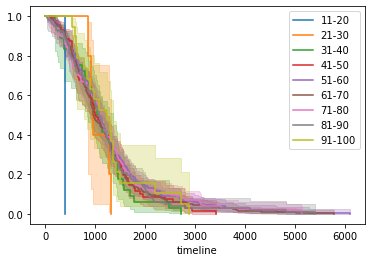

In [148]:
kmf = KaplanMeierFitter()

T = df_Colorectal['Colorectal_Duration']
E = df_Colorectal['Censored']


groups =  df_Colorectal['Age_Range']

#ix1 = (groups == '<10')
ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
ix10 = (groups == '91-100')
#ix11 = (groups == '100+')

#kmf.fit(T[ix1], E[ix1], label='<10')    
#ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='11-20')       
ax = kmf.plot()

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)


kmf.fit(T[ix10], E[ix10], label='91-100')         
ax9 = kmf.plot(ax=ax)

#kmf.fit(T[ix11], E[ix11], label='100+')         
#ax10 = kmf.plot(ax=ax)


    

It seems younger people (age group: 11-20 and 21-30) have the lowest survival rate, though they have few data points. Besides, age group 31-40 has the lowest survival rate.

# 16.	Which age group has the highest survival for lung cancer at the end of the study?

In [149]:
df_Lung['Age_Range'].value_counts()

61-70     469
71-80     463
51-60     253
81-90     202
41-50      53
91-100     24
31-40      10
21-30       6
100+        1
11-20       1
<10         1
Name: Age_Range, dtype: int64

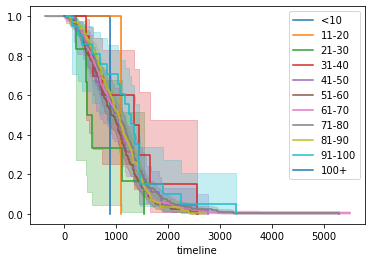

In [150]:
kmf = KaplanMeierFitter()

T = df_Lung['Lung_Duration']
E = df_Lung['Censored']


groups =  df_Lung['Age_Range']

ix1 = (groups == '<10')
ix2 = (groups == '11-20')
ix3 = (groups == '21-30')
ix4 = (groups == '31-40')
ix5 = (groups == '41-50')
ix6 = (groups == '51-60')
ix7 = (groups == '61-70')
ix8 = (groups == '71-80')
ix9 = (groups == '81-90')
ix10 = (groups == '91-100')
ix11 = (groups == '100+')

kmf.fit(T[ix1], E[ix1], label='<10')    
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='11-20')       
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='21-30')    
ax2 = kmf.plot(ax=ax)


kmf.fit(T[ix4], E[ix4], label='31-40')         
ax3 = kmf.plot(ax=ax)

kmf.fit(T[ix5], E[ix5], label='41-50')       
ax4 = kmf.plot(ax=ax)

kmf.fit(T[ix6], E[ix6], label='51-60')    
ax5 = kmf.plot(ax=ax)


kmf.fit(T[ix7], E[ix7], label='61-70')         
ax6 = kmf.plot(ax=ax)

kmf.fit(T[ix8], E[ix8], label='71-80')       
ax7 = kmf.plot(ax=ax)

kmf.fit(T[ix9], E[ix9], label='81-90')    
ax8 = kmf.plot(ax=ax)


kmf.fit(T[ix10], E[ix10], label='91-100')         
ax9 = kmf.plot(ax=ax)

kmf.fit(T[ix11], E[ix11], label='100+')         
ax10 = kmf.plot(ax=ax)


    

Age group 41-50 has the highest survival for lung cancer at the end of the study.

# 17.	What is the survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis?

In [151]:
df_Pancreatic_Age21_Age30 = df_Pancreas[df_Pancreas['Age_Range'] == '21-30']

In [152]:
df_Pancreatic_Age21_Age30.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,PANCREAS,PANCREAS_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Pancreas_Duration
584,1988-01-27,2016-08-25,Female,1,2015-12-29,2016-08-25,1,White,29,21-30,240
1477,1985-11-04,2015-11-26,Female,1,2015-11-18,2016-08-25,0,Black/African-American,30,21-30,8
5257,1989-04-20,2016-08-25,Male,1,2016-03-25,2016-08-25,1,White,27,21-30,153


In [153]:
kmf_Age21_Age30_Pancreatic = KaplanMeierFitter()
kmf_Age21_Age30_Pancreatic.fit(df_Pancreatic_Age21_Age30['Pancreas_Duration'], df_Pancreatic_Age21_Age30['Censored'], label = 'Age21_Age30')

<lifelines.KaplanMeierFitter:"Age21_Age30", fitted with 3 total observations, 1 right-censored observations>

Text(0, 0.5, 'Survival')

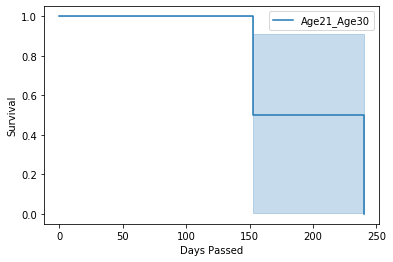

In [155]:
kmf_Age21_Age30_Pancreatic.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [156]:
kmf_Age21_Age30_Pancreatic.predict(365)

0.0

Survival rate for 21_30 age group with pancreatic cancer after 1 years (365 days) since diagnosis is 0.0 or 0%

# 19. What is the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis?

In [157]:
df_Thyroid_Age51_Age60 = df_Thyroid[df_Thyroid['Age_Range'] == '51-60']

In [158]:
df_Thyroid_Age51_Age60.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,THYROID,THYROID_DT,DATE_CUTOFF,Censored,Race,age,Age_Range,Thyroid_Duration
156,1960-02-26,2016-08-25,Female,1,2008-02-13,2016-08-25,1,Black/African-American,57,51-60,3116
246,1965-03-15,2016-08-25,Female,1,2014-03-17,2016-08-25,1,White,51,51-60,892
406,1959-03-04,2016-08-25,Male,1,2014-12-24,2016-08-25,1,Black/African-American,58,51-60,610
555,1964-04-25,2016-08-25,Female,1,2014-07-10,2016-08-25,1,White,52,51-60,777
969,1959-11-03,2016-08-25,Female,1,2012-09-25,2016-08-25,1,Other,57,51-60,1430


In [159]:
kmf_Age51_Age60_Thyroid = KaplanMeierFitter()
kmf_Age51_Age60_Thyroid.fit(df_Thyroid_Age51_Age60['Thyroid_Duration'], df_Thyroid_Age51_Age60['Censored'], label = 'Age51_Age60')

<lifelines.KaplanMeierFitter:"Age51_Age60", fitted with 168 total observations, 1 right-censored observations>

In [160]:
# kmf_Female.cumulative_density_

Text(0, 0.5, 'Survival')

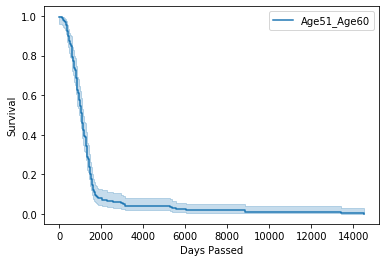

In [161]:
kmf_Age51_Age60_Thyroid.plot()

plt.xlabel("Days Passed")
plt.ylabel('Survival')

In [162]:
kmf_Age51_Age60_Thyroid.predict(2200)

0.07254464285714288

Survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis is 0.07 or 7%

# 20.	which race has the high survival for all cancers after 2500 days since diagnosis?

Comparing the figures of survival rate by race, high survival race for all cancers after 2500 days since diagnosis is:

Lung: White, Pancreas: White, Thyroid: White, Coloractal :Asian, and Melanoma: White 

#### Overall, white has the high survival rate.